# Creating point source objects in SimCADO

This notebook focuses on creating `Source` objects for SimCADO. Topics inclued

* [Brief introduction to the Source object](#Brief-introduction-to-the-Source-object)
    * Creating a ``Source`` object the hard way
    * Creating a ``Source`` object the easy way
* [Creating a star](#Creating-a-star)
* [Creating a group of stars using 2MASS](#Creating-a-group-of-stars-using-2MASS)
* [Inbuilt SEDs](#Inbuilt-SEDs)

## Brief introduction to the Source object

The ``Source`` object describes the distribution of light coming from an object to SimCADO, in three dimensions: (x,y, $\lambda$). This information is held in 6 lists:
* ``<Source>.x``
* ``<Source>.y``
* ``<Source>.lam``
* ``<Source>.spectra``
* ``<Source>.ref``
* ``<Source>.weight``

For N stars ``.x`` and ``.y`` are 1D-arrays with length N and correspond to the (x,y) coordinated of the object on the focal plane, in units of [arcsec] from the centre.

``.lam`` is independent of the number of sources. It is the number of spectral bins in the wavelength range covered by the spectrum - i.e. M=180 for a spectrum with 10nm bins in the range [0.7um, 2.5um). It has length M

If all N stars had a different spectrum, then `.spectra` would be a 2D-array with the shape (N, M). If, however, we only have Q spectral types in the group of N stars, (where Q < N) we can save space and computation time, by having each star reference a spectrum in the 2D array.  
`.spectra` now has the size (Q, M).

The array ``.ref`` is used to connect the N stars to the Q unique spectra. The length of ``.ref`` is N, but the maximum value is Q. The integers contained in ``.ref`` refer to the position of the spectrum in ``.spectra`` which should be used for any given coordinate.  

For example, to get the (x,y) coordinates and the correct spectrum for a star, we would need to call:  

``src.x[i], src.y[i], src.spectra[src.ref[i]]``

The ``.weight`` array is also a 1D array with length N. This allows stars with the same spectrum, and hence the same ``.ref`` value to have different brightnesses. This is useful for compensating for differences in distance and/or age.

### Creating a ``Source`` object the hard way

**Note:** SimCADO contains the module ``simcado.source`` and the object ``simcado.source.Source()``. The upper and lower cases should not be forgotten. The ``Source()`` object is originally inside the ``source`` module, however to make life easier, it can also be called straight from the main simcado module with ``simcado.Source()``.

If we want to create a ``Source`` from scratch, we will need all 6 arrays.

In [1]:
import numpy as np
import simcado

x = np.array([0, 0.4, 1.2, -2.5])   # random x,y coordinated for 4 stars
y = np.array([0, -0.6, 1.2, 1.2])
lam, spec = simcado.source.SED(spec_type=["A0V", "G2V"], filter_name="K", magnitude=[0,0])
ref = np.array([0,0,0,1])
weight = np.array([1E-10, 1E-15, 1E-12, 1E-20])

src = simcado.Source(lam=lam, spectra=spec, x=x, y=y, ref=ref, weight=weight)

### Creating a ``Source`` object the easy way

Because we're nice, we've written a range of functions to help create ``Source`` objects:

* Point Sources:
      simcado.source.star()
      simcado.source.stars()
      simcado.source.star_grid()
      simcado.source.cluster()
* Extended sources:
      simcado.source.source_from_image()
      simcado.source.empty_sky()
        
Each of these functions have a describtion on how to use them in their docstring. The easiest way to call this up is either with the ``?`` caller in ipython, or by hitting ``shift+tab`` in Jupyter Notebook while the cursor is over the function name. For example:

In [2]:
simcado.source.cluster?

In the folling sections we will look at making ``Source`` objects for point sources. Extended sources will be covered in another Jupyter Notebook

## Creating a star

To begin with lets start with alpha Centauri

In [3]:
import simcado

alphaCen = simcado.source.star(spec_type="G2V", mag=0.01, filter_name="V")

print("Alpha Cen", alphaCen.x, alphaCen.y, alphaCen.ref, alphaCen.spectra.shape, alphaCen.weight)

Alpha Cen [0] [0] [0] (1, 2700) [ 0.99083194]


The values printed above are the arrays for ``.x``, ``.y`` and ``.ref`` as well as the shape of the ``.spectra`` array for the alpha Centauri ``Source`` object. As we only have one object in this ``Source``, there is only one value in each array and one spectrum in ``.spectra`` covering 2700 spectral bins.

Now lets create two ``Source`` objects for beta Centauri and proxima Centauri and place them 2 and 4 arcseconds away from alpha Centauri respectively (yes, I know this isn't realistic).

In [4]:
betaCen = simcado.source.star(spec_type="K1V", mag=1.33, filter_name="V", x=2, y=0)
proxCen = simcado.source.star(spec_type="M5V", mag=11.13, filter_name="V", x=0, y=4)

print("Beta Cen", betaCen.x, betaCen.y, betaCen.ref, betaCen.spectra.shape, betaCen.weight)
print("Proxima Cen", proxCen.x, proxCen.y, proxCen.ref, proxCen.spectra.shape, proxCen.weight)

Beta Cen [2] [0] [0] (1, 2700) [ 0.29376497]
Proxima Cen [0] [4] [0] (1, 2700) [  3.53183170e-05]


In order to simulate an observation we need to combine all the stars into one source. 

In [5]:
groupCen = alphaCen + betaCen + proxCen

Easy. Now when we look at the arrays for ``groupCen`` we see all the stars are present

In [6]:
print("Proxima Cen", groupCen.x, groupCen.y, groupCen.ref, groupCen.spectra.shape, groupCen.weight)

Proxima Cen [0 2 0] [0 0 4] [0 1 2] (3, 2700) [  9.90831945e-01   2.93764965e-01   3.53183170e-05]


To simulate an observation we could call

In [7]:
sim_obs = simcado.run(groupCen, detector_layout="centre")

Detector layout
 id x_cen y_cen x_len y_len gain
--- ----- ----- ----- ----- ----
  0     0     0  4096  4096  1.7
Creating 1 layer(s) per chip
1 chip(s) will be simulated
Reading out chip 0


however, observing two stars which are visible with the naked eye with a 40m telescope will produce questionable results.

To get an idea of how many photons will be arriving on the detector from each of the stars we can apply the Ks-band filter curve to the ``Source`` object and then call the method: ``<Source>.photons_in_range()``.

In [8]:
ks = simcado.optics.get_filter_curve("Ks")
print("ph/s/m2:", (groupCen * ks).photons_in_range())

ph/s/m2: [  5.09871560e+09   2.81914354e+09   1.48521431e+07]


## Creating a group of stars using 2MASS

Say we want to get all stars that 2MASS has for the centre of the globular cluster M4. We can use the ``astroquery`` package to pull all stars within a 30 arcsecond radius of the centre from the 2MASS catalogue:

For more on AstroQuery: https://astroquery.readthedocs.io/en/latest/  
If you don't have AstroQuery: 
    
    $ pip install astroquery

In [9]:
import numpy as np
from astropy import units as u
from astroquery.irsa import Irsa
Irsa.ROW_LIMIT = 5000
 
m4_stars = Irsa.query_region("245.927928 -26.572311", catalog="fp_psc", 
                                spatial="Cone", radius=30*u.arcsec)
print(m4_stars)

   ra     dec       clon     ...          h_k                  j_k          id
  deg     deg                ...                                              
------- ------- ------------ ... --------------------- ------------------- ---
245.925 -26.574 16h23m41.93s ...                    --                  --   0
245.922 -26.572 16h23m41.21s ...   0.16700000000000001 0.88800000000000001   1
245.921 -26.575 16h23m41.13s ...                 0.191 0.65600000000000003   2
245.919 -26.572 16h23m40.55s ...                 0.127 0.57099999999999995   3
245.926 -26.577 16h23m42.18s ...   0.47699999999999998 0.92400000000000004   4
245.921 -26.577 16h23m41.04s ...   0.14799999999999999 0.65200000000000002   5
245.925 -26.580 16h23m42.03s ...                    --                  --   6
245.924 -26.578 16h23m41.77s ...   0.13500000000000001 0.58899999999999997   7
245.928 -26.578 16h23m42.84s ...   0.19600000000000001 0.60499999999999998   8
245.933 -26.578 16h23m43.82s ... -0.0290000000000000

To make a ``Source`` out of this table, we need to convert the RA and Dec coordinates into (x,y) in units of [arcsec] from the centre. 

In [10]:
x = (m4_stars["ra"]  - np.average(m4_stars["ra"])).data  * 3600
y = (m4_stars["dec"] - np.average(m4_stars["dec"])).data * 3600

Unfortunately 2MASS doesn't provide a spectral classification, so we will assume all stars are sun-like G2V stars. 2MASS does however give us Ks-Band magnitudes, so we can use these to scale the spectra accordingly.

In [11]:
mags = m4_stars["k_m"].data
print(mags)

[16.007 14.466 14.417 13.6 15.122 13.889 16.017 14.568 14.606 14.394 14.176
 13.622 14.125 14.009 13.967 14.519 14.014 14.896 15.041 14.529 14.527
 14.167 13.511 14.009 14.509 14.397 13.203 12.53 14.096 13.678 15.962
 14.511 14.327 14.798 15.493 14.388 15.533 11.322]


While we could create ``Source`` objects for all the stars individually, theres is an easier way: ``simcado.source.stars()``

In [12]:
m4_src = simcado.source.stars(spec_types=["G2V"]*len(mags), mags=mags, filter_name="Ks", x=x, y=y)

We can now push this through SimCADO with the ``.run()`` command

In [13]:
m4_obs = simcado.run(m4_src, detector_layout="centre")

Detector layout
 id x_cen y_cen x_len y_len gain
--- ----- ----- ----- ----- ----
  0     0     0  4096  4096  1.7
Creating 1 layer(s) per chip
1 chip(s) will be simulated
Reading out chip 0


When we visualise the results iof a 60 second exposure on the central chip, we see that it's not very interesting. Only 4 stars are visible. This is because 2MASS is limited to 16th magnitude in Ks-band. We would need to artificially fill out the ``Source`` object with the low mass stars to create a proper cluster.

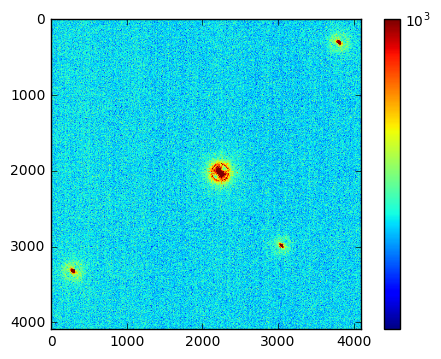

In [14]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

plt.imshow(m4_obs[0].data, norm=LogNorm(), vmax=1000)
plt.colorbar()

For this purpose, simcado has the function ``.source.cluster()``. Here we can generate an object for a cluster based on an Kroupa IMF. (However we don't yet have an age dependency implemented, so all the young stars are still included).

The half mass radius is 8 ly according to http://messier.seds.org/m/m004.html

In [15]:
m4_artificial = simcado.source.cluster(mass=6.7E4, distance=2200, half_light_radius=8/3.26)

m4_art_im = simcado.run(m4_artificial, detector_layout="centre")

Detector layout
 id x_cen y_cen x_len y_len gain
--- ----- ----- ----- ----- ----
  0     0     0  4096  4096  1.7
Creating 1 layer(s) per chip
1 chip(s) will be simulated
Reading out chip 0


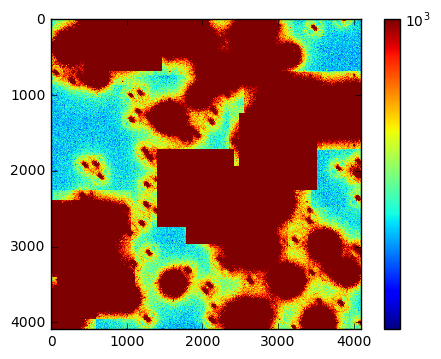

In [16]:
plt.imshow(m4_art_im[0].data, norm=LogNorm(), vmax=1000)
plt.colorbar()

## Inbuilt SEDs

In [17]:
simcado.source.get_SED_names()
lam, spec = simcado.source.SED()

TypeError: SED() missing 1 required positional argument: 'spec_type'